# Import

In [1]:
from absl import flags
import sys
FLAGS = flags.FLAGS
FLAGS(sys.argv[:1])

import time # 프레임 당 시간 계산하기위해서 필요함
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images
from yolov3_tf2.utils import convert_boxes

from bytetrack import preprocessing # NMS
from bytetrack import matching
from bytetrack.detection import Detection
from bytetrack.tracker import BYTETracker
from bytetrack.tracking_utils import match_detections_with_tracks, convert_boxes

from typing import List

# Detection Model Load

In [6]:
class_names = [c.strip() for c in open('./data/labels/coco.names').readlines()] # [car, person, ... ]
yolo = YoloV3(classes=len(class_names))
yolo.load_weights('./weights/yolov3.tf')

# frame 단위로 video capture 

In [8]:
'''동영상 파일 사용시
# frame 단위로 video capture
vid = cv2.VideoCapture('./data/video/test.mp4')

codec = cv2.VideoWriter_fourcc(*'XVID')
vid_fps = int(vid.get(cv2.CAP_PROP_FPS)) # CAP_PROP_FPS는 float을 반환해서 int로 바꿔줌 
vid_width, vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results.avi', codec, vid_fps, (vid_width, vid_height))
'''

## Vis-Drone 데이터셋 받아오기

In [3]:
import glob

vis_directory = 'C:/Users/Son\Documents/aiffel/SIA-MOT/VisDrone2019-MOT-val/VisDrone2019-MOT-val/sequences/uav0000086_00000_v/'
images_filepaths = sorted(glob.glob(vis_directory+"*"))
print(len(images_filepaths))

464


In [5]:
a = cv2.imread(images_filepaths[1])
a_height, a_width = a.shape[0], a.shape[1]
codec = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('./data/video/results.avi', codec, 30, (a_width, a_height))

# Tracking Start

In [7]:
# tracker class 선언
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

args = BYTETrackerArgs()
tracker = BYTETracker(args)

model_filename = 'model_data/mars-small128.pb'

In [5]:

''' 동영상 파일 사용시
while True:
    
    _, img = vid.read() # img : ndarray (height, width,channel) 한장씩 받아옴
    if img is None:
        print('Completed')
        break
    
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0) # detector에 넣어주기 위해서 (1,height, width, channel)로 만들어줌 >> tf.Tensor로 바뀜
    img_in = transform_images(img_in, 416)  # 1. image resize >> 416으로, 2. 픽셀값 255로 나눠줌. 
    
    t1 = time.time()
    
    boxes, scores, classes, nums = yolo.predict(img_in)
    
    classes = classes[0]
    
    #####################################################
    # 여기부터 bytetrack폴더에 있는 파일 사용

    # box정보가 [0,0,0,0]이 아닌 것만 받음
    # box shape : x_min, y_min, w, h로 바뀜 & image 크기로 reshape
    converted_boxes = convert_boxes(img, boxes[0])

    # 박스정보 : left, top, width, height
    detections = [Detection(bbox, score, classes) for bbox, score, classes in
                  zip(converted_boxes, scores[0], classes)]

    boxs = np.array([d.to_xyxy() for d in detections]) # to_xyxy : left, top, width, height에서 x_min, y_min, x_max, y_max로 바꿔줌
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.classes for d in detections])

    tracks = tracker.update(
            output_results= np.hstack((boxs, scores[:, np.newaxis])),
            img_info=img_in.shape,
            img_size=img_in.shape
        )
    
    # match_detections_with_tracks를 해줄 필요는 없는 거 같은데 왜 쓴 건지는 알아보는 중
    # 현재 detection box와 현재추적중인 track사이의 IoU matching
    # 더 정확히 matching시켜주기 위함이 아닐까 함.
    track_id = match_detections_with_tracks(boxs=boxs, tracks=tracks)
    for i,detection in enumerate(detections):
        detection.add_track_id(track_id[i])
    
    mask = np.array([detection.track_id is not None for detection in detections], dtype=bool)
    classes = classes[mask]
    detections = list(np.array(detections)[mask])
    
    ############################################
    # tracking 확인/ 시각화 과정
    
    cmap = plt.get_cmap('tab20b') # 숫자를 색상에 매핑
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)] # 20개 색상 생성

    current_count = int(0)
    
    for i, detection in enumerate(detections):
        if detection is None:
            continue
        bbox = detection.to_xyxy() # cv2 출력에 사용됨 min_x, min_y, max_x, max_y
        class_name = class_names[int(detection.classes)]
        color = colors[int(detection.track_id) % len(colors)]
        color = [i*255 for i in color]

        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]),int(bbox[3])), color, 2) # lt, rb
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                        +len(str(detection.track_id)))*17,int(bbox[1])), color, -1) # id box
        cv2.putText(img, class_name+"-"+str(detection.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                        (255,255,255), 2)
    
    fps  = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.namedWindow("output", cv2.WINDOW_NORMAL)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    out.write(img)

    if cv2.waitKey(1) == ord('q'): # 휴식
        break
vid.release()
out.release()
cv2.destroyAllWindows()
'''

1/1 [==============================] - 1s 818ms/step


KeyboardInterrupt: 

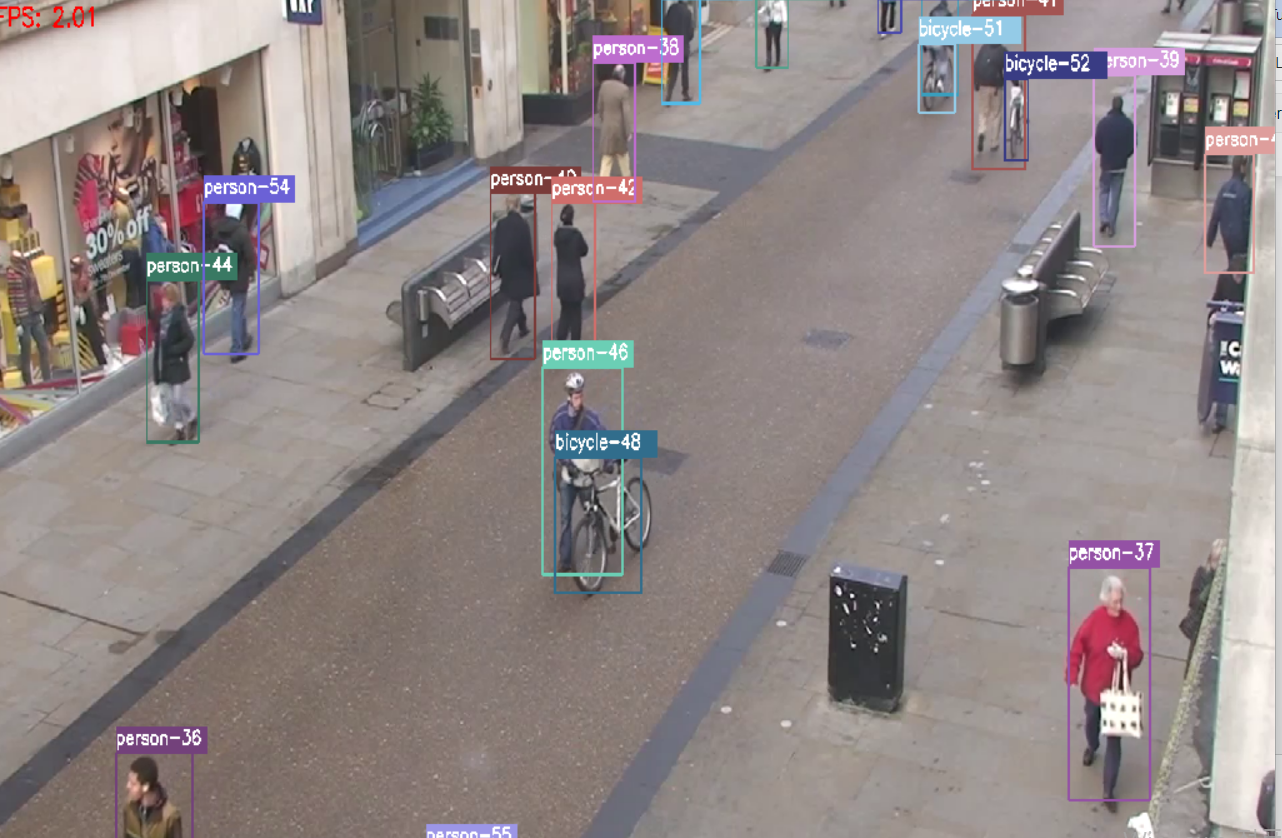

In [10]:
for img in images_filepaths:  
    if img is None:
        print('Completed')
        break
    
    img = cv2.imread(img)
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0) # detector에 넣어주기 위해서 (1,height, width, channel)로 만들어줌 >> tf.Tensor로 바뀜
    img_in = transform_images(img_in, 416)  # 1. image resize >> 416으로, 2. 픽셀값 255로 나눠줌.
    
    t1 = time.time()
    
    boxes, scores, classes, nums = yolo.predict(img_in)
    
    classes = classes[0]
    
    #####################################################
    # 여기부터 bytetrack폴더에 있는 파일 사용

    # box정보가 [0,0,0,0]이 아닌 것만 받음
    # box shape : x_min, y_min, w, h로 바뀜 & image 크기로 reshape
    converted_boxes = convert_boxes(img, boxes[0])

    # 박스정보 : left, top, width, height
    detections = [Detection(bbox, score, classes) for bbox, score, classes in
                  zip(converted_boxes, scores[0], classes)]

    boxs = np.array([d.to_xyxy() for d in detections]) # to_xyxy : left, top, width, height에서 x_min, y_min, x_max, y_max로 바꿔줌
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.classes for d in detections])

    tracks = tracker.update(
            output_results= np.hstack((boxs, scores[:, np.newaxis])),
            img_info=img_in.shape,
            img_size=img_in.shape
        )
    
    # match_detections_with_tracks를 해줄 필요는 없는 거 같은데 왜 쓴 건지는 알아보는 중
    # 현재 detection box와 현재추적중인 track사이의 IoU matching
    # 더 정확히 matching시켜주기 위함이 아닐까 함.
    track_id = match_detections_with_tracks(boxs=boxs, tracks=tracks)
    for i,detection in enumerate(detections):
        detection.add_track_id(track_id[i])
    
    mask = np.array([detection.track_id is not None for detection in detections], dtype=bool)
    classes = classes[mask]
    detections = list(np.array(detections)[mask])
    
    ############################################
    # tracking 확인/ 시각화 과정
    
    cmap = plt.get_cmap('tab20b') # 숫자를 색상에 매핑
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)] # 20개 색상 생성

    current_count = int(0)
    
    for i, detection in enumerate(detections):
        if detection is None:
            continue
        bbox = detection.to_xyxy() # cv2 출력에 사용됨 min_x, min_y, max_x, max_y
        class_name = class_names[int(detection.classes)]
        color = colors[int(detection.track_id) % len(colors)]
        color = [i*255 for i in color]

        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]),int(bbox[3])), color, 2) # lt, rb
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                        +len(str(detection.track_id)))*17,int(bbox[1])), color, -1) # id box
        cv2.putText(img, class_name+"-"+str(detection.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                        (255,255,255), 2)
    
    fps  = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.namedWindow("output", cv2.WINDOW_NORMAL)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    out.write(img)

    if cv2.waitKey(1) == ord('q'): # 휴식
        break
#vid.release()
out.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 591ms/step


1/1 [==============================] - 1s 752ms/step


1/1 [==============================] - 0s 497ms/step


1/1 [==============================] - 1s 513ms/step
